<IPython.core.display.Javascript object>


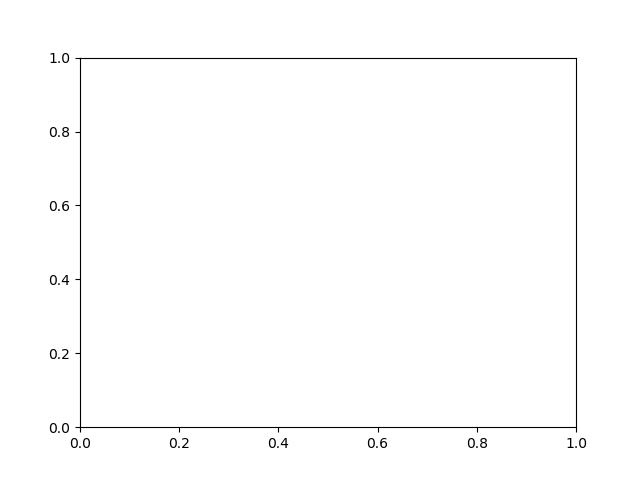

<IPython.core.display.Javascript object>


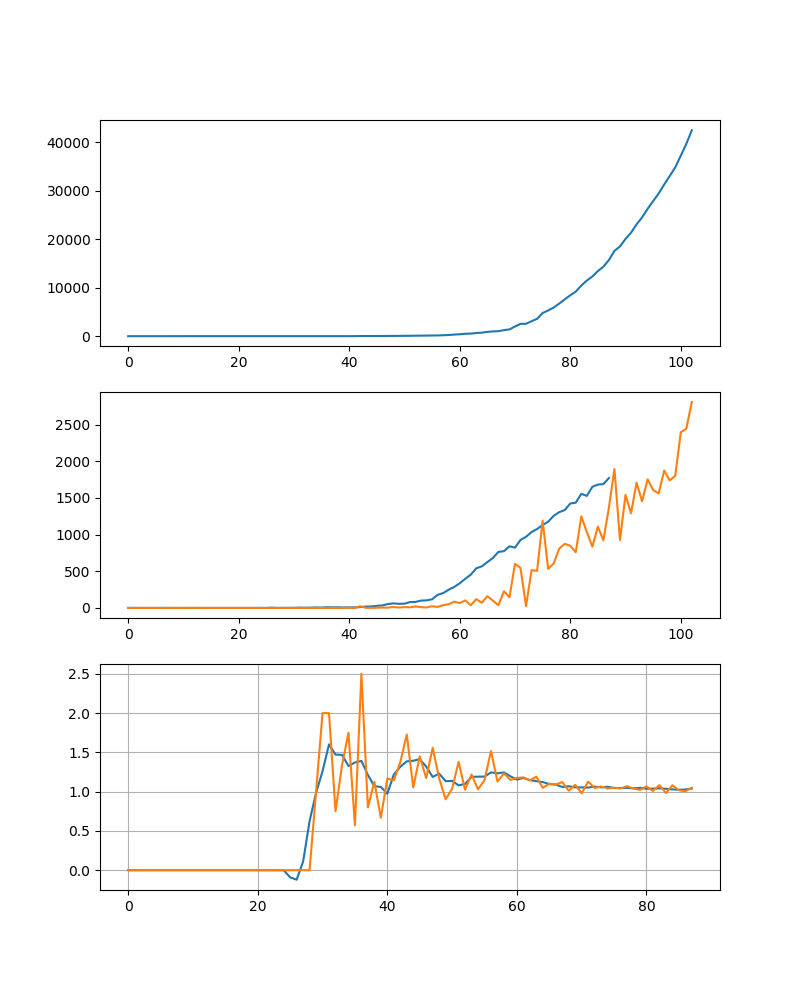

'\ndef dd_country_eventhandler(change):\n    #print(change.new)\n    countryCode=change.new\n    plotGraphs(countryCode)\n\n\ncountries={"India":"IND","Japan":"JPN","China":"CHN","Australia":"AUS"}\ndd_country = widgets.Dropdown(options = countries)\ndisplay(dd_country)\nplotGraphs(countries[list(countries.keys())[0]])\ndd_country.observe(dd_country_eventhandler, names=\'value\')\n'

In [4]:
import requests,json,random
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from scipy.signal import savgol_filter

def getData(countryCode):
    url = 'https://covidapi.info/api/v1/country/'+countryCode
    response = requests.get(url)
    if response.status_code==200:
        data= json.loads(response.content)['result']
        days=[{**data[d],'date':d} for d in data]# Merging two dicts
        return days
    else:
        return

def calculateNewReportedCases(days):
    newReportedCases=[0 for x in days]
    for i in range(len(days)):
        if i>0:
            newReportedCases[i]=days[i]['confirmed']-days[i-1]['confirmed']
    return newReportedCases

def calculateNewTrueCases(newReportedCases):
    newTrueCases=[0 for x in newReportedCases]
    mu, sigma = -10, 3
    cutoff=15 #only calculating till those dates, that would have led to cases being reported
    for i in range(len(newReportedCases)):
        dist = np.around(np.random.normal(mu, sigma, abs(newReportedCases[i])))# taking abs for taking of weird data that number of confirmed cases decreased
        dayOffsets, counts = np.unique(dist, return_counts=True)
        for j in range(len(dayOffsets)):
            dayOffset=dayOffsets[j]
            day=int(i+dayOffset)
            if(day>0 and day<(len(newReportedCases)-1)):
                if(newReportedCases[i]>0):
                    newTrueCases[day]+=counts[j]
                else:
                    newTrueCases[day]-=counts[j]# again for those negative values that come in some data.
    return newTrueCases[:-cutoff]

def calculateR(newTrueCases):
    """
    i = 0
    moving_averages = []
    window_size=5
    while i < len(newTrueCases) - window_size + 1:
        this_window = newTrueCases[i : i + window_size]
        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += 1

    newTrueCases=moving_averages
    """
    r=[0 for x in newTrueCases]
    for i in range(1,len(newTrueCases)):
        if(newTrueCases[i-1]>0):
            r[i]=newTrueCases[i]/newTrueCases[i-1]
            #print("{} : {}".format(days[i+window_size]['date'],r[i]))
    return r
    

def plotGraphs(countryCode):
    days=getData(countryCode)
    if (not days):
        print('No data available for country')
    else:
        active=[day['confirmed']-day['recovered']-day['deaths'] for day in days]
        newReportedCases=calculateNewReportedCases(days)
        newTrueCases=calculateNewTrueCases(newReportedCases)
        R=calculateR(newTrueCases)
        Rs = savgol_filter(R, 9, 3)#smoothing
        plt.cla()
        fig, graphs = plt.subplots(3, 1, figsize = (8, 10))
        g1=graphs[0]
        g1.plot([day['confirmed'] for day in days])
        g2 = graphs[1]
        g2.plot(newTrueCases)
        g2.plot(newReportedCases)
        g3 = graphs[2]
        g3.plot(Rs)
        g3.plot(R)
        g3.grid()

plotGraphs('IND')
"""
def dd_country_eventhandler(change):
    #print(change.new)
    countryCode=change.new
    plotGraphs(countryCode)


countries={"India":"IND","Japan":"JPN","China":"CHN","Australia":"AUS"}
dd_country = widgets.Dropdown(options = countries)
display(dd_country)
plotGraphs(countries[list(countries.keys())[0]])
dd_country.observe(dd_country_eventhandler, names='value')
"""